<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers

In [14]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [15]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [16]:
train_images = train_images / 255.0

test_images = test_images / 255.0

In [17]:
model = tf.keras.Sequential()

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(216, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='sigmoid', kernel_regularizer=regularizers.l2(0.00001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# # model.add(layers.Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(500, activation='relu', kernel_regularizer=regularizers.l2(0.000001)))
# model.add(layers.Dropout(0.5))
# # model.add(layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10, activation='softmax'))
# model.add(layers.Softmax())

In [18]:
model.compile(#optimizer='adam',
              optimizer='adamax',
              # optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(train_images,
                    train_labels,
                    epochs=120,
                    batch_size=128,
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

Epoch 1/120
469/469 [==============================] - 5s 10ms/step - loss: 0.5542 - accuracy: 0.8131 - val_loss: 0.4649 - val_accuracy: 0.8400
Epoch 2/120
469/469 [==============================] - 4s 9ms/step - loss: 0.4245 - accuracy: 0.8559 - val_loss: 0.4302 - val_accuracy: 0.8513
Epoch 3/120
469/469 [==============================] - 5s 10ms/step - loss: 0.3849 - accuracy: 0.8675 - val_loss: 0.4025 - val_accuracy: 0.8596
Epoch 4/120
469/469 [==============================] - 5s 10ms/step - loss: 0.3601 - accuracy: 0.8753 - val_loss: 0.3900 - val_accuracy: 0.8645
Epoch 5/120
469/469 [==============================] - 4s 9ms/step - loss: 0.3391 - accuracy: 0.8832 - val_loss: 0.3855 - val_accuracy: 0.8638
Epoch 6/120
469/469 [==============================] - 5s 10ms/step - loss: 0.3259 - accuracy: 0.8872 - val_loss: 0.3756 - val_accuracy: 0.8668
Epoch 7/120
469/469 [==============================] - 5s 10ms/step - loss: 0.3131 - accuracy: 0.8900 - val_loss: 0.3578 - val_accuracy: 0

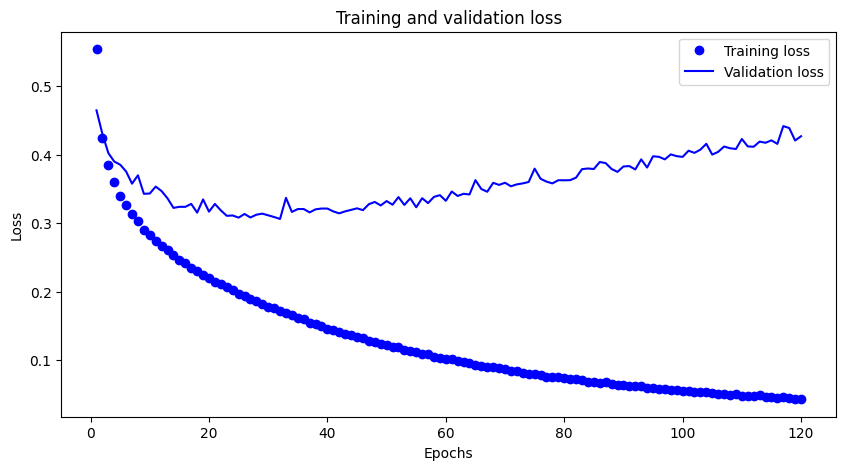

<Figure size 640x480 with 0 Axes>

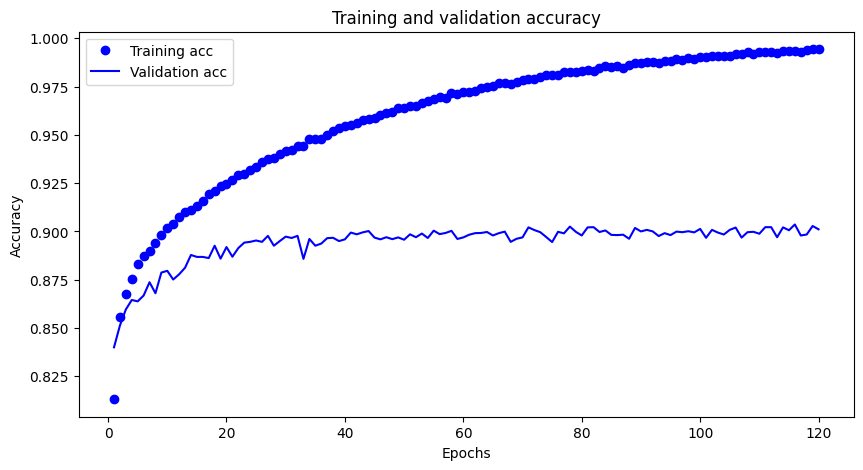

In [20]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [21]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [22]:
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 3ms/step


In [23]:
predictions[0]

array([0.08533677, 0.08533677, 0.08533677, 0.08533677, 0.08533677,
       0.08533679, 0.08533677, 0.08533693, 0.08533677, 0.23196888],
      dtype=float32)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407050 (1.55 MB)
Trainable params: 407050 (1.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
